# FIRST ORDER MODEL FOR PROPOSED ENFIELD BUILDING

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
class Person:
    """
    A class that represents a person at the food pantry.
    """
    # ATTRIBUTES:
    # Attribute order: the order the person visits the pressure points in the food pantry
    # Invariant: order is a list of Pressure_Points
    #
    # Attribute available: whether or not the person is available to go to the next station
    # Invariant: available is a boolean value
    #
    # Attribute enter: the time the person enters the food pantry
    # Invariant: enter is a positive int
    #
    # Attribute leave: the time the person leaves the food pantry
    # Invariant: leave is a positive int
    #
    # Attribute shopping_time: the total time spent shopping
    # Invariant: shopping_time is an int which is the sum of each Pressure_Point.time in self.order
    
    
    
    def __init__(self, model):
        """
        Initializes a Person object entering Model model.
        """
        self.order = model.pressure_points.copy()
        
        # Randomly chooses whether person goes to each station based on Pressure_Point.p
        i=0
        while i < len(self.order):
            if np.random.uniform() > self.order[i].p:
                self.order.pop(i)
            else:
                i += 1
        random.shuffle(self.order)
        
        # Set total time spent shopping
        self.shopping_time = 0
        for i in self.order:
            self.shopping_time += i.time
        
        # Set remaining attributes
        self.enter = model.iterations
        self.available = True
        
    def setLeave(self, iterations):
        """
        Sets the time the person leaves the food pantry.
        """
        self.leave = iterations
        
    def __str__(self):
        """
        Returns a string representing the person. i.e. the stations the person has to visit
        """
        str = "Stations remaining: "
        for i in self.order:
            str += ", " + i.name
        return str
        
class Pressure_Point:
    """
    A class that represents a pressure point in the food pantry.
    """
    # ATTRIBUTES:
    # Attribute name: the name of the pressure point
    # Invariant: name is a string
    #
    # Attribute capacity: the number of people that can shop at the pressure point at a time
    # Invariant: capacity is an int >= 0
    #
    # Attribute time: the time people spend at the pressure point
    # Invariant: time is an int >= 1
    #
    # Attribute atCapacity: whether or not the pressure point is full
    # Invariant: atCapacity is a boolean value
    #
    # Attribute people: the people shopping at the pressure point
    # Invariant: people is a list of People objects
    #
    # Attribute timeRemaining: the time each person in self.people has remaining at the pressure point
    # Invariant: timeRemaining is a list of ints >= 0 with the same length as self.people
    #
    # Attribute p: the probability a person shops at this pressure point
    # Invariant: p is an int or float between 0 and 1
    
    
    
    def __init__(self, name, capacity, time, p = 1):
        """
        Initializes a Pressure_Point object.
        """
        self.name = name
        self.capacity = capacity
        self.time = time
        self.atCapacity = False
        self.people = []
        self.timeRemaining = []
        self.p = p
        
        
    def update(self):
        """
        Updates attributes of the Pressure_Point after one minute has passed.
        """
        i = 0
        while i < len(self.timeRemaining):
            self.timeRemaining[i] -= 1
            if self.timeRemaining[i] == 0:
                self.timeRemaining.pop(i)
                self.people[i].available = True
                self.people.pop(i)
                self.atCapacity = False
            else:
                i += 1
            
    def add(self, person):
        """
        Attempts to add Person person to shop at this Pressure_Point.
        """
        # Checks if full
        if not self.atCapacity:
            person.available = False
            self.people.append(person)
            self.timeRemaining.append(self.time)
            person.order.pop(0)
            if len(self.people) == self.capacity:
                self.atCapacity = True
    
    def __str__(self):
        """
        Returns a string representing this pressure point. 
        i.e. how much time each person at the pressure point has left to shop.
        """
        #return "Number of People: " + str(len(self.people))
        return "Time Remaining: " + str(self.timeRemaining)

class Model:
    """
    A class that represents a simulation model.
    """
    # ATTRIBUTES:
    # Attribute cars: the number of cars that arrive at the food pantry daily
    # Invariant: cars is an int or float >= 0
    #
    # Attribute per_car: the number of adults in each car
    # Invariant: per_car is an int > 0
    #
    # Attribute hours_open: the number of hours open per day
    # Invariant: hours_open is an int or float >= 0
    #
    # Attribute arrival_rate: the number of cars that arrive at the food pantry per minute
    # Invariant: arrival_rate is an int or float >= 0
    #
    # Attribute pressure_points: the pressure_points in the food pantry
    # Invariant: pressure_points is a list of Pressure_Point objects
    #
    # Attribute iterations: how many minutes have been simulated in the model
    # Invariant: iterations is an int >= 0
    #
    # Attribute people: the people currently in the food pantry
    # Invariant: people is a list of People objects
    #
    # Attribute arrival_count: the amount of people that should have shown up since the last person
    # Invariant: arrival_count is an int or float >= 0
    #
    # Attribute people_arrived: the amount of people who arrived on the current day
    # Invariant: people_arrived is an int >= 0
    #
    # Attribute day: the current day being simulated
    # Invariant: day is an int >= 0
    #
    # Attribute stats: the data collected from simulating
    # Invariant: stats is a list of pandas DataFrames
    #
    # Attribute arrival_stats: the amount of people who arrived on each day
    # Invariant: arrival_stats is a list of ints >= 0
    #
    # Attribute day_df: the stats for the current day
    # Invariant: day_df is a pandas DataFrame
    
    
    
    def setPressurePoints(self, names, times, capacities, ps):
        """
        Initializes self.pressure_points.
        """
        assert len(names) == len(times)
        assert len(names) == len(capacities)
        
        self.pressure_points = []
        
        for i in range(len(names)):
            self.pressure_points.append(Pressure_Point(names[i], capacities[i], times[i], ps[i]))
    
    
    def __init__(self, cars, per_car, hours_open, names, times, capacities, ps):
        """
        Initializes an instance of a model.
        """
        self.cars = cars
        self.per_car = per_car
        self.arrival_rate = cars / (hours_open * 60)
        self.hours_open = hours_open
        self.setPressurePoints(names, times, capacities, ps)
        self.iterations = 0
        self.people = []
        self.arrival_count = 0
        self.people_arrived = 0
        self.day = 0
        self.stats = []
        self.arrival_stats = []
        self.day_df = pd.DataFrame(columns = ['enter', 'leave'])
        
        
    def iterate(self):
        """
        Performs the actions of one minute in the food pantry.
        """
        self.iterations += 1
        self.arrival_count += self.arrival_rate
        
        # Simulate people arriving
        while self.arrival_count >= 1:
            for j in range(self.per_car):
                self.people.append(Person(self))
                self.people_arrived += 1
            self.arrival_count -= 1
        
        # Update each Pressure_Point
        for i in self.pressure_points:
            i.update()
        
        # Simulate people leaving and shopping at each Pressure_Point and collect data
        i = 0
        while i < len(self.people):
            if len(self.people[i].order) == 0 and self.people[i].available:
                self.people[i].setLeave(self.iterations)
                self.day_df.loc[len(self.day_df.index)] = [self.day, self.people[i].enter, self.people[i].leave, 
                                                           self.people[i].leave - self.people[i].enter,
                                                           self.people[i].shopping_time, 
                                                           self.people[i].leave - self.people[i].enter - self.people[i].shopping_time]
                self.people.pop(i)
            else:
                if self.people[i].available:
                    self.people[i].order[0].add(self.people[i])
                i += 1
                
        # Print the state of the model
        # self.print_state()
                
            
    def simulate_day(self):
        """
        Runs simulation for one day.
        """
        self.day += 1
        i = 0
        self.arrival_count = 0
        self.people_arrived = 0
        self.people = []
        self.day_df = pd.DataFrame(columns = ['day', 'enter', 'leave', 'total_time', 'shopping_time', 'waiting_time'])
        while i < self.hours_open * 60:
            i += 1
            self.iterate()
        self.stats.append(self.day_df)
        self.arrival_stats.append(self.people_arrived)
        
        
    def print_state(self):
        """
        Prints the current state of the model.
        """
        print("PEOPLE:")
        for i in self.people:
            print(str(i))
        print("PRESSURE POINTS:")
        for i in self.pressure_points:
            print(str(i))    
                
                
    def simulate(self, days):
        """
        Runs the simulation for days days.
        """
        for i in range(days):
            self.simulate_day()

In [8]:
# Initialize the model with given data from Enfield
cars = 65
per_car = 2
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes"]
times = [5, 5, 5, 10]
capacities = [3, 3, 3, 7]
ps = [1, 1, 1, .25]
enfield = Model(cars, per_car, hours_open, names, times, capacities, ps)

In [9]:
# Run the simulation for 14 days
enfield.simulate(14)

In [10]:
# Collect aggregate data in one DataFrame
df = pd.DataFrame(columns = ['day',
                             'shoppers_served',
                             'shoppers_arrived',
                             'avg_total_time',
                             'avg_shopping_time',
                             'avg_waiting_time'])
for i in range(len(enfield.stats)):
    df.loc[len(df.index)] = [int(enfield.stats[i]['day'][0]),
                             len(enfield.stats[i].index),
                             enfield.arrival_stats[i],
                             enfield.stats[i]['total_time'].mean(),
                             enfield.stats[i]['shopping_time'].mean(),
                             enfield.stats[i]['waiting_time'].mean()]
df

,day,shoppers_served,shoppers_arrived,avg_total_time,avg_shopping_time,avg_waiting_time
0,1.0,92.0,130.0,32.260870,17.282609,14.978261
1,2.0,93.0,130.0,34.333333,17.365591,16.967742
2,3.0,95.0,130.0,32.568421,17.000000,15.568421
3,4.0,91.0,130.0,36.263736,17.087912,19.175824
4,5.0,93.0,130.0,34.010753,17.365591,16.645161
5,6.0,94.0,130.0,35.638298,17.872340,17.765957
6,7.0,93.0,130.0,35.150538,17.150538,18.000000
7,8.0,94.0,130.0,34.170213,17.872340,16.297872
8,9.0,95.0,130.0,34.673684,17.105263,17.568421
9,10.0,94.0,130.0,33.436170,17.872340,15.563830


In [8]:
df.mean().round(2)

day                    7.50
shoppers_served       93.21
shoppers_arrived     130.00
avg_total_time        34.50
avg_shopping_time     17.45
avg_waiting_time      17.05
dtype: float64

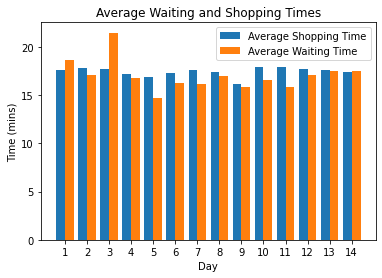

In [21]:
X = df['day'].astype('int32')
Yshoptime = df['avg_shopping_time']
Zwaittime = df['avg_waiting_time']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Yshoptime, 0.4, label = 'Average Shopping Time')
plt.bar(X_axis + 0.2, Zwaittime, 0.4, label = 'Average Waiting Time')
  
plt.xticks(X_axis, X)
plt.xlabel("Day")
plt.ylabel("Time (mins)")
plt.title("Average Waiting and Shopping Times")
plt.legend()
plt.show()

In [25]:
round(df.mean()[4]/df.mean()[5], 4)

1.0235